In [13]:
# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pymongo import MongoClient
import os
import warnings
import sys
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")

library_path = os.path.abspath('..')
if library_path not in sys.path:
    sys.path.append(library_path)

PLOTS_PATH = os.path.join(library_path, 'plots')

print("Libraries imported successfully!")
print(f"Current working directory: {os.getcwd()}")

Libraries imported successfully!
Current working directory: /mnt/DataVol/CGE/voice_parkinson_database/analysis_notebooks


In [29]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["Diagnosis_Severity_PD_Voice"]
collection = db["studies"]

print("🔄 Loading studies from MongoDB...")
fields_to_extract = {
    "doi"             : 1, 
    "year"            : 1, 
    "study_id"        : 1,
    "ml_approaches"   : 1,
    "problem"         : 1,
    '_id'             : 0
}  # 1 = include, 0 = exclude
studies_cursor = collection.find({}, fields_to_extract)
studies_list = list(studies_cursor)


print(f"📊 Total studies loaded: {len(studies_list)}")
print(f"📄 Sample document keys: {list(studies_list[0].keys()) if studies_list else 'No documents found'}")

🔄 Loading studies from MongoDB...
📊 Total studies loaded: 381
📄 Sample document keys: ['year', 'doi', 'ml_approaches', 'study_id', 'problem']


In [30]:
def get_scaling(experiment_list:list)->list:

    scaling_list = []

    for experiment in experiment_list:
        scaling = experiment.get('scaling')
        if scaling is None:
            scaling = []
        scaling_list += scaling

    return list(set(scaling_list))

def experiments_with_scaling(experiment_list: list)->int:

    count = 0
    for experiment in experiment_list:
        if experiment.get('scaling') is not None:
            count+=1
    return count

def get_algorithms(experiment_list:list)->list:

    algorithm_list = []

    for experiment in experiment_list:
        algorithms = experiment.get('algorithm')
        if algorithms is None:
            continue
        algorithm_list.append(algorithms)

    return list(set(algorithm_list))

In [31]:
experiment_df = pd.DataFrame(studies_list)
experiment_df['num_experiments'] = experiment_df['ml_approaches'].apply(lambda x: len(x))
experiment_df['exp_with_scaling'] = experiment_df['ml_approaches'].apply(lambda x: experiments_with_scaling(x))
experiment_df.head()

,year,doi,ml_approaches,study_id,problem,num_experiments,exp_with_scaling
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0
1,2020,10.1007/s11517-020-02260-3,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s11517-020-02260-3_1,Parkinson's disease diagnosis,4,0
2,2020,10.1007/s13755-020-00104-w,"[{'algorithm': 'Logistic Regression', 'framewo...",10.1007/s13755-020-00104-w_1,Parkinson's disease diagnosis,22,22
3,2020,10.1007/s42452-020-2826-9,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s42452-020-2826-9_1,Parkinson's disease diagnosis,3,0
4,2020,10.1007/s42452-020-2826-9,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s42452-020-2826-9_2,Parkinson's disease diagnosis,3,0


In [32]:
num_experiments = experiment_df['num_experiments'].sum()
experiments_with_scaling = experiment_df['exp_with_scaling'].sum()

print(f"Total number of experiments: {num_experiments}")
print(f"Number of experiments with scaling: {experiments_with_scaling}")
print(f"NNumber of experiments without scaling: {num_experiments-experiments_with_scaling}")
print(f"Percentage of experiments with scaling: {experiments_with_scaling/num_experiments*100:.2f}%")
print(f"Number of papers: {experiment_df['doi'].nunique()}")

Total number of experiments: 2431
Number of experiments with scaling: 785
NNumber of experiments without scaling: 1646
Percentage of experiments with scaling: 32.29%
Number of papers: 260


In [33]:
experiment_df['scaling'] = experiment_df['ml_approaches'].apply(
    lambda x: get_scaling(x)
)
experiment_df['algorithms'] = experiment_df['ml_approaches'].apply(
    lambda x: get_algorithms(x)
)
algorithm_df = experiment_df.explode('algorithms')
algorithm_df = algorithm_df.explode('scaling')
algorithm_df.head(7)

,year,doi,ml_approaches,study_id,problem,num_experiments,exp_with_scaling,scaling,algorithms
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,NaN,Gaussian Process: ARD Squared Exponential Kernel
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,NaN,Gaussian Process: ARD Exponential Kernel
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,NaN,Gaussian Process: ARD Matern 3/2 Kernel
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,NaN,Gaussian Process: ARD Matern 5/2 Kernel
1,2020,10.1007/s11517-020-02260-3,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s11517-020-02260-3_1,Parkinson's disease diagnosis,4,0,NaN,Naive Bayes
1,2020,10.1007/s11517-020-02260-3,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s11517-020-02260-3_1,Parkinson's disease diagnosis,4,0,NaN,Random Forest
1,2020,10.1007/s11517-020-02260-3,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s11517-020-02260-3_1,Parkinson's disease diagnosis,4,0,NaN,K-Nearest Neighbors


In [34]:
algorithm_df['base_algorithm'] = algorithm_df['algorithms'].apply(
    lambda x: x.split(':')[0] if isinstance(x, str) else x)
algorithm_df['base_algorithm'] = algorithm_df['base_algorithm'].apply(lambda x: x.split('(')[0].strip())
algorithm_df.head()

,year,doi,ml_approaches,study_id,problem,num_experiments,exp_with_scaling,scaling,algorithms,base_algorithm
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,NaN,Gaussian Process: ARD Squared Exponential Kernel,Gaussian Process
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,NaN,Gaussian Process: ARD Exponential Kernel,Gaussian Process
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,NaN,Gaussian Process: ARD Matern 3/2 Kernel,Gaussian Process
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,NaN,Gaussian Process: ARD Matern 5/2 Kernel,Gaussian Process
1,2020,10.1007/s11517-020-02260-3,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s11517-020-02260-3_1,Parkinson's disease diagnosis,4,0,NaN,Naive Bayes,Naive Bayes


In [35]:
print(f"Total unique algorithms: {algorithm_df['base_algorithm'].nunique():,}")
print(f"Total of papers: {algorithm_df['doi'].nunique():,}")

Total unique algorithms: 147
Total of papers: 260


In [36]:
def clean_technique_name(technique):
    """
    Clean technique names by extracting the base strategy.
    Handles both colon-separated and parentheses-separated details.
    """
    if not isinstance(technique, str):
        return str(technique)
    
    # Remove leading/trailing whitespace
    cleaned = technique.strip()
    
    # Handle specific name standardizations first
    if (cleaned == "CDIL-CNN Experiment 3" or 
        cleaned == "CDIL-CNN Experiment 1" or 
        cleaned == "CDIL-CNN Experiment 2"):
        cleaned = "CDIL-CNN"

    if (cleaned == "InceptionTime Experiment 1" or 
        cleaned == "InceptionTime Experiment 2" or 
        cleaned == "InceptionTime Experiment 3"):
        cleaned = "InceptionTime"

    if (cleaned == "LSTM-FCN Experiment 1" or 
        cleaned == "LSTM-FCN Experiment 2" or 
        cleaned == "LSTM-FCN Experiment 3"):
        cleaned = "LSTM-FCN"

    # Additional cleanup for common patterns
    # Remove trailing dashes or other separators
    cleaned = cleaned.rstrip(' -–—_')
    
    return cleaned

In [37]:
algorithm_df['cleaned_algorithm'] = algorithm_df['base_algorithm'].apply(clean_technique_name)
algorithm_df.head()

,year,doi,ml_approaches,study_id,problem,num_experiments,exp_with_scaling,scaling,algorithms,base_algorithm,cleaned_algorithm
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,NaN,Gaussian Process: ARD Squared Exponential Kernel,Gaussian Process,Gaussian Process
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,NaN,Gaussian Process: ARD Exponential Kernel,Gaussian Process,Gaussian Process
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,NaN,Gaussian Process: ARD Matern 3/2 Kernel,Gaussian Process,Gaussian Process
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,NaN,Gaussian Process: ARD Matern 5/2 Kernel,Gaussian Process,Gaussian Process
1,2020,10.1007/s11517-020-02260-3,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s11517-020-02260-3_1,Parkinson's disease diagnosis,4,0,NaN,Naive Bayes,Naive Bayes,Naive Bayes


In [44]:
tech_by_paper = algorithm_df.groupby(by=['doi', 'problem'], as_index=False).agg({'cleaned_algorithm': set})
tech_by_paper = tech_by_paper.explode('cleaned_algorithm')

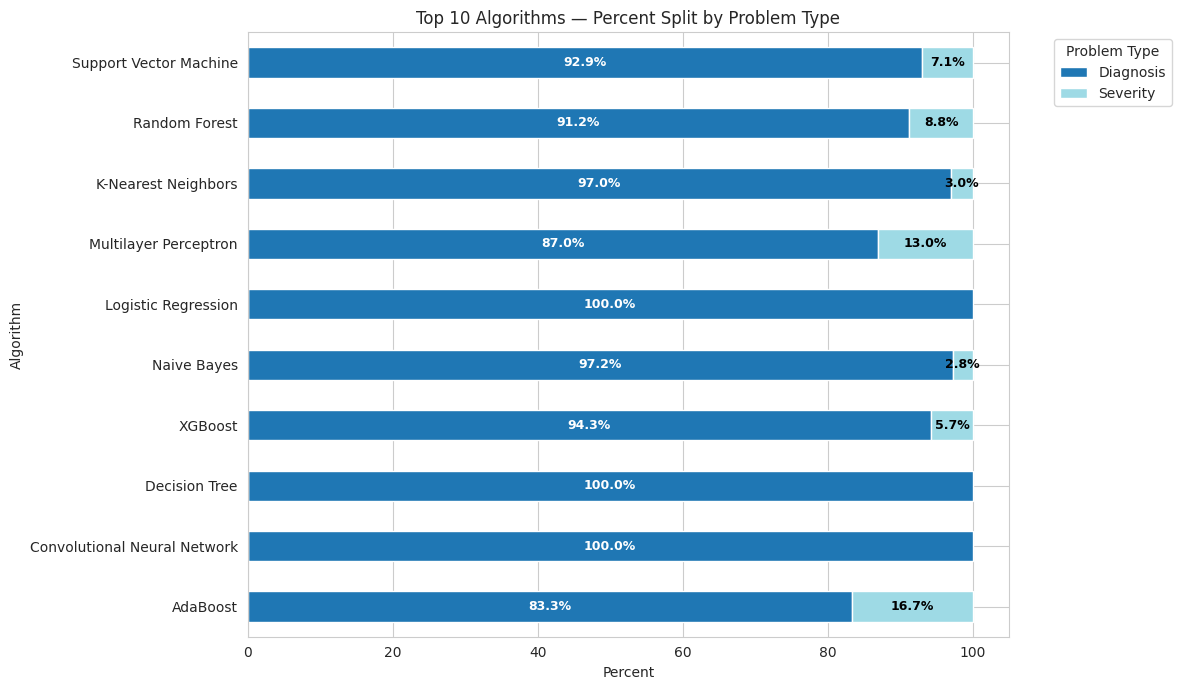

In [64]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Get top 10 algorithms
technique_rank = (
    tech_by_paper['cleaned_algorithm']
    .value_counts()
    .reset_index()
)
technique_rank.columns = ['algorithm', 'count']
top10 = technique_rank['algorithm'].head(10).tolist()

# 2. Filter only top 10
filtered = tech_by_paper[tech_by_paper['cleaned_algorithm'].isin(top10)].copy()

# Standardize problem names
filtered['problem'] = filtered['problem'].replace({
    "Parkinson's disease diagnosis": 'Diagnosis',
    "Parkinson's disease severity stage classification": 'Severity'
})

# 3. Count occurrences
alg_prob_counts = (
    filtered
    .groupby(['cleaned_algorithm', 'problem'])
    .size()
    .reset_index(name='count')
)

# 4. Pivot raw counts
pivot = (
    alg_prob_counts
    .pivot(index='cleaned_algorithm', columns='problem', values='count')
    .fillna(0)
)

# 5. Percent pivot (100% stacked data)
pivot_percent = pivot.div(pivot.sum(axis=1), axis=0) * 100

# 6. Order algorithms bottom→top
ordered_algorithms = technique_rank['algorithm'].head(10).tolist()[::-1]
pivot_percent = pivot_percent.reindex(ordered_algorithms)

# 7. Plot 100% stacked bar chart
ax = pivot_percent.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 7),
    colormap='tab20'
)

plt.title('Top 10 Algorithms — Percent Split by Problem Type')
plt.xlabel('Percent')
plt.ylabel('Algorithm')

# 8. Add percent labels inside segments
import matplotlib.colors as mcolors

colors = plt.cm.tab20.colors  # consistent order

for y, alg in enumerate(ordered_algorithms):
    row = pivot_percent.loc[alg]
    x_pos = 0

    for problem, color, percent in zip(pivot_percent.columns, colors, row):
        if percent > 0:
            # compute brightness for readable text
            r, g, b = mcolors.to_rgb(color)
            brightness = 0.299*r + 0.587*g + 0.114*b
            text_color = 'black' if brightness > 0.7 else 'white'

            ax.text(
                x_pos + percent / 2,
                y,
                f"{percent:.1f}%",
                va='center',
                ha='center',
                fontsize=9,
                color=text_color,
                fontweight='bold'
            )

        x_pos += percent

plt.legend(title='Problem Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [65]:
technique_rank = tech_by_paper['cleaned_algorithm'].value_counts().reset_index()
technique_rank.columns = ['algorithm', 'count']
technique_rank['percentage'] = np.round(technique_rank['count'] / technique_rank['count'].sum() * 100, 2)
technique_rank.head(10)

,algorithm,count,percentage
0,Support Vector Machine,99,13.83
1,Random Forest,80,11.17
2,K-Nearest Neighbors,66,9.22
3,Multilayer Perceptron,46,6.42
4,Logistic Regression,42,5.87
5,Naive Bayes,36,5.03
6,XGBoost,35,4.89
7,Decision Tree,30,4.19
8,Convolutional Neural Network,29,4.05
9,AdaBoost,18,2.51


In [66]:
import textwrap

def break_long_names(name, max_len=22, max_lines=3):
    wrapped = textwrap.wrap(
        name,
        width=max_len,
        break_long_words=False,
        break_on_hyphens=False
    )

    # Limit number of lines
    if len(wrapped) > max_lines:
        wrapped = wrapped[:max_lines]
        wrapped[-1] += "…"

    return "\n".join(wrapped)

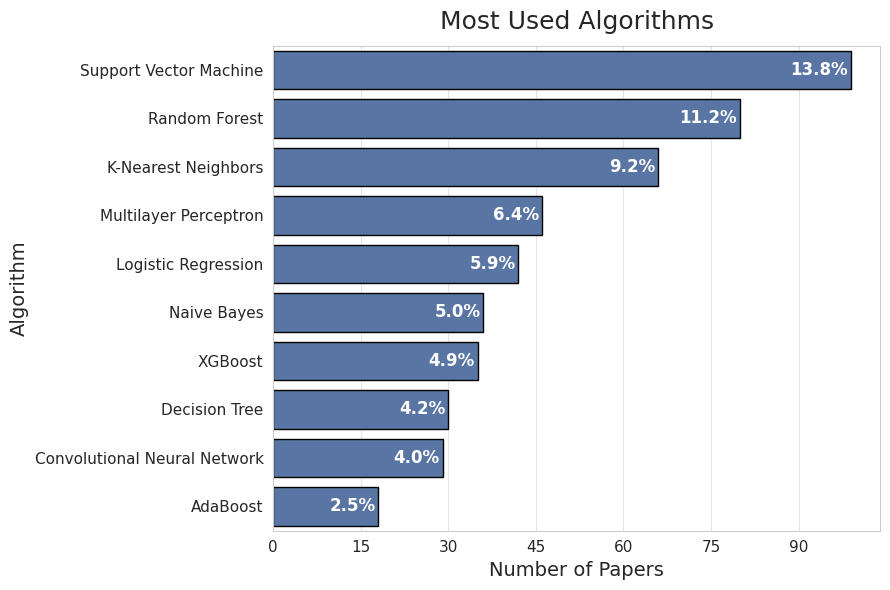

In [67]:
top10_techniques = technique_rank.head(10)
from matplotlib.ticker import MaxNLocator


# Seaborn style
sns.set_style("whitegrid")

# Figure size (single-column journal size)
plt.figure(figsize=(9, 6))

# Calculate percentages
percentages = top10_techniques['percentage']

# Bar plot
ax = sns.barplot(
    x=top10_techniques['count'],
    y=top10_techniques['algorithm'],
    color="#4C72B0",
    edgecolor="black"
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Labels and title
ax.set_title("Most Used Algorithms", fontsize=18, pad=12)
ax.set_xlabel("Number of Papers", fontsize=14)
ax.set_ylabel("Algorithm", fontsize=14)

# Ticks
ax.tick_params(axis='both', labelsize=11)

# Add value and percentage labels on bars (closer to the end of the bars)
for i, (v, pct) in enumerate(zip(top10_techniques['count'], percentages)):
    ax.text(v - 0.5, i, f"{pct:.1f}%", va='center', ha='right', fontsize=12, fontweight='bold', color='white')

# Improve grid appearance
ax.grid(axis='x', color="#E5E5E5")
ax.grid(axis='y', visible=False)

# Tight layout for clean export
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, 'feat_ext_barplot.svg'), dpi=600)


In [75]:
algorithm_df['scaling'] = algorithm_df['scaling'].fillna('No Scaling')
algorithm_df['has_scale'] = algorithm_df['scaling'].apply(lambda x: 0 if x == 'No Scaling' else 1)
algorithm_df

,year,doi,ml_approaches,study_id,problem,num_experiments,exp_with_scaling,scaling,algorithms,base_algorithm,cleaned_algorithm,has_scale
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,No Scaling,Gaussian Process: ARD Squared Exponential Kernel,Gaussian Process,Gaussian Process,0
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,No Scaling,Gaussian Process: ARD Exponential Kernel,Gaussian Process,Gaussian Process,0
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,No Scaling,Gaussian Process: ARD Matern 3/2 Kernel,Gaussian Process,Gaussian Process,0
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,Parkinson's disease diagnosis,4,0,No Scaling,Gaussian Process: ARD Matern 5/2 Kernel,Gaussian Process,Gaussian Process,0
1,2020,10.1007/s11517-020-02260-3,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s11517-020-02260-3_1,Parkinson's disease diagnosis,4,0,No Scaling,Naive Bayes,Naive Bayes,Naive Bayes,0
...,...,...,...,...,...,...,...,...,...,...,...,...
376,2024,10.1016/j.heliyon.2024.e34593,"[{'algorithm': 'Multilayer Perceptron', 'scali...",10.1016/j.heliyon.2024.e34593_1,Parkinson's disease severity stage classification,1,1,Min Max,Multilayer Perceptron,Multilayer Perceptron,Multilayer Perceptron,1
377,2025,10.1016/j.compbiomed.2024.109565,[{'algorithm': 'Stacked Ensemble (Logistic Reg...,10.1016/j.compbiomed.2024.109565_1,Parkinson's disease severity stage classification,1,0,No Scaling,"Stacked Ensemble (Logistic Regression, Random ...",Stacked Ensemble,Stacked Ensemble,0
378,2025,10.1016/j.eswa.2025.126503,"[{'algorithm': 'Adaptive K-Nearest Neighbor', ...",10.1016/j.eswa.2025.126503_1,Parkinson's disease diagnosis,1,0,No Scaling,Adaptive K-Nearest Neighbor,Adaptive K-Nearest Neighbor,Adaptive K-Nearest Neighbor,0
379,2025,10.1109/ACCESS.2025.3597851,"[{'algorithm': 'Fused Neural Network', 'framew...",10.1109/EICEEAI60672.2023.10590358_1,Parkinson's disease severity stage classification,1,1,Min Max,Fused Neural Network,Fused Neural Network,Fused Neural Network,1


In [81]:
algs_scaled = algorithm_df.groupby(by=['cleaned_algorithm', 'has_scale'], as_index=False).size()
top10_algs_scaled = algs_scaled[algs_scaled['cleaned_algorithm'].isin(top10)].reset_index(drop=True)

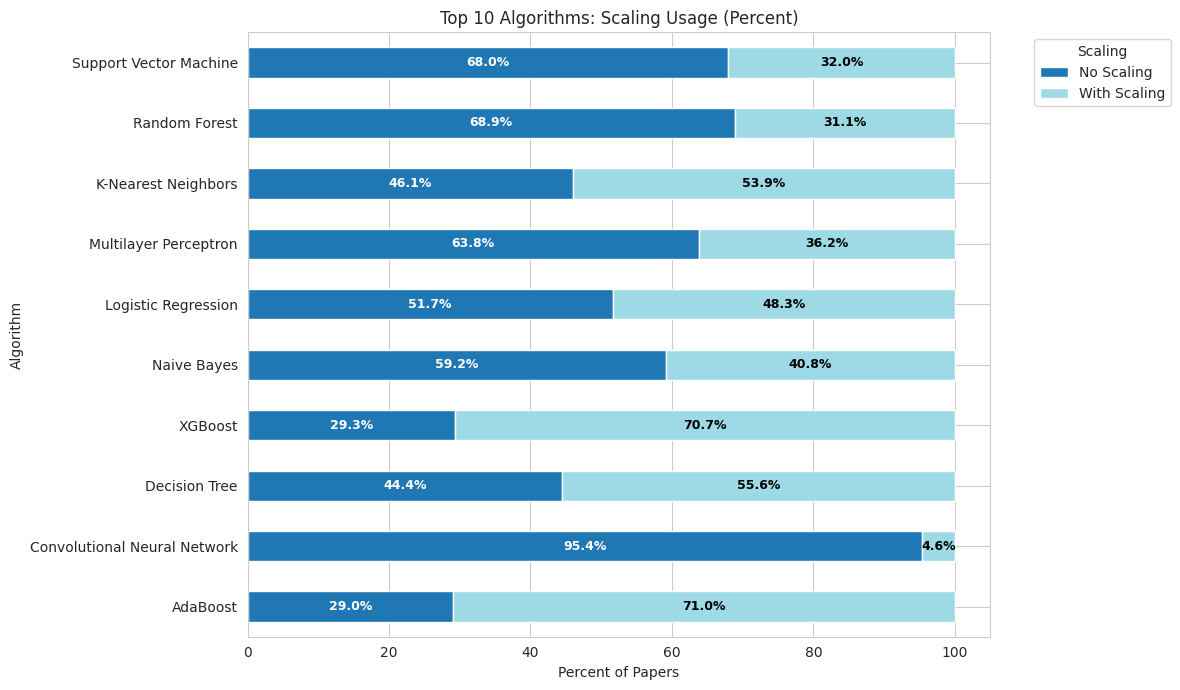

In [83]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 1. Pivot into wide format
pivot_scaled = (
    top10_algs_scaled
    .pivot(index='cleaned_algorithm', columns='has_scale', values='size')
    .fillna(0)
)

# 2. Order algorithms as before (reverse top10 list)
pivot_scaled = pivot_scaled.reindex(top10[::-1])

# 3. Convert counts → percent per algorithm
pivot_scaled_percent = pivot_scaled.div(pivot_scaled.sum(axis=1), axis=0) * 100

# 4. Plot using same style as previous figure
ax = pivot_scaled_percent.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 7),
    colormap='tab20'     # <<< same colormap as previous plot
)

plt.title('Top 10 Algorithms: Scaling Usage (Percent)')
plt.xlabel('Percent of Papers')
plt.ylabel('Algorithm')

# 5. Legend update (consistent placement + style)
plt.legend(
    ['No Scaling', 'With Scaling'],
    title='Scaling',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

# 6. Add percentage labels inside the stacked bars (same font logic)
colors = plt.cm.tab20.colors   # use matching colors

for y, alg in enumerate(pivot_scaled_percent.index):
    row = pivot_scaled_percent.loc[alg]
    x_pos = 0

    for (col, color, percent) in zip(pivot_scaled_percent.columns, colors, row):

        if percent > 0:
            # dynamic text color (same as previous plot)
            r, g, b = mcolors.to_rgb(color)
            brightness = (0.299*r + 0.587*g + 0.114*b)
            text_color = 'black' if brightness > 0.7 else 'white'

            ax.text(
                x_pos + percent/2,
                y,
                f"{percent:.1f}%",
                va='center',
                ha='center',
                fontsize=9,
                color=text_color,
                fontweight='bold'
            )

        x_pos += percent

plt.tight_layout()
plt.show()
